# Example Likelihood Test

This notebook tests the implementation of a standard minimal firecrown likelihood which can be used with the blinding library.

In [1]:
%matplotlib inline
import pylab as plt
from firecrown.likelihood.likelihood import NamedParameters
import numpy as np
import sacc
import pyccl as ccl
import sys
import os

# suppress warnings
import warnings
warnings.filterwarnings("ignore")
from smokescreen import ConcealDataVector

In [2]:
sys.path.append("../examples/cosmic_shear/")
import cosmicshear_likelihood

Now let's try to pass the loaded sacc object

In [3]:
sacc_file = "../examples/cosmic_shear/cosmicshear_sacc.fits"
sacc_data = sacc.Sacc.load_fits(sacc_file)
build_parameters =  NamedParameters({
    "sacc_data": sacc_data,
})

## Testing now with the blinding library

In [14]:
cosmo = ccl.CosmologyVanillaLCDM()
syst_dict = {
    "trc1_delta_z": 0.1,
    "trc0_delta_z": 0.1,
    }
shift_dict = {"Omega_c": (0.20, 0.34), "sigma8": (0.58, 0.91)}
sck = ConcealDataVector(cosmo, cosmicshear_likelihood, shift_dict, sacc_data, systm_dict=syst_dict, **{'debug': True})

[DEBUG] Shifts: {'Omega_c': 0.23912704758534112, 'sigma8': 0.6663515613200941}
[DEBUG] Concealed Cosmology: <pyccl.cosmology.Cosmology>
	Neff    = 3.044
	Omega_b = 0.05
	Omega_c = 0.23912704758534112
	h       = 0.67
	n_s     = 0.96
	sigma8  = 0.6663515613200941
	extra_parameters =
	HASH_ACCURACY_PARAMS = 0xac359e1a3db0fd01
[DEBUG] Likelihood requires systematics: ['trc0_delta_z', 'trc1_delta_z']


In [15]:
sck.calculate_concealing_factor(factor_type='add')
blinded_datavect = sck.apply_concealing_to_likelihood_datavec()

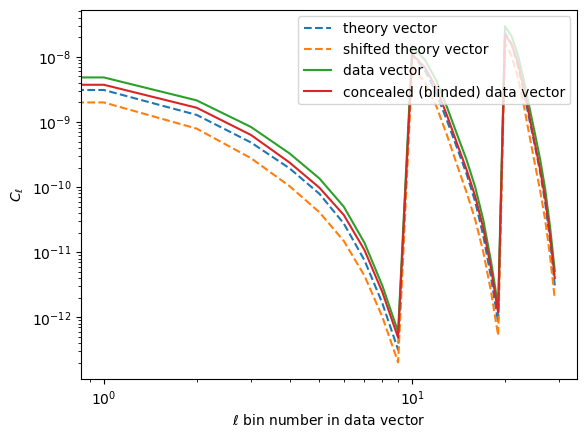

In [16]:
plt.figure()
plt.loglog(sck.theory_vec_fid, ls='--', label='theory vector')
plt.loglog(sck.theory_vec_conceal, ls='--', label='shifted theory vector')
plt.loglog(sck.likelihood.get_data_vector(), label='data vector')
plt.loglog(blinded_datavect, label='concealed (blinded) data vector')
plt.legend(loc=1)
plt.xlabel(r'$\ell$ bin number in data vector')
plt.ylabel(r'$C_{\ell}$')
plt.show()

Saving the sacc object

In [17]:
# delete the concealed data vector before saving it to avoid errors:
if os.path.exists("../examples/cosmic_shear/cosmicshear_sacc_concealed_data_vector.fits"):
    os.remove("../examples/cosmic_shear/cosmicshear_sacc_concealed_data_vector.fits")

sck.save_concealed_datavector("../examples/cosmic_shear/", "cosmicshear_sacc")

## Properly plotting each of the data vectors

In [18]:
concealed_sacc = sacc.Sacc.load_fits("../examples/cosmic_shear/cosmicshear_sacc_concealed_data_vector.fits")

# Type of power spectra
data_types = np.unique([d.data_type for d in concealed_sacc.data])
print("Data types: ", data_types)

# Tracer combinations
print("Tracer combinations: ", concealed_sacc.get_tracer_combinations())

# Data size
print("Size: ", concealed_sacc.mean.size)

Data types:  ['galaxy_shear_cl_ee']
Tracer combinations:  [(np.str_('trc0'), np.str_('trc0')), (np.str_('trc0'), np.str_('trc1')), (np.str_('trc1'), np.str_('trc1'))]
Size:  30


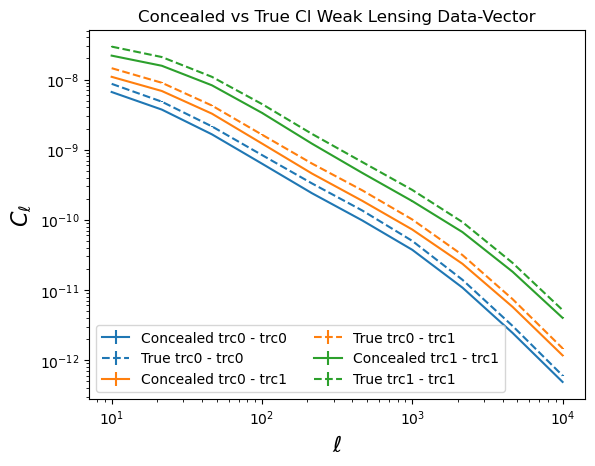

In [19]:
plt.figure()
i=0
plt.title('Concealed vs True Cl Weak Lensing Data-Vector')
for t1, t2 in concealed_sacc.get_tracer_combinations():
    l, cl, cov = concealed_sacc.get_ell_cl(None, t1, t2, return_cov=True)
    lt, clt, covt = sacc_data.get_ell_cl(None, t1, t2, return_cov=True)
    err = np.sqrt(np.diag(cov))
    errt = np.sqrt(np.diag(covt))
    plt.errorbar(l, cl, err, color=f'C{i}', label='Concealed %s - %s' % (t1, t2))
    plt.errorbar(lt, clt, errt, ls='--', color=f'C{i}', label='True %s - %s' % (t1, t2))
    i+=1
plt.loglog()
plt.legend(ncol=2)
plt.xlabel(r'$\ell$',fontsize=16)
plt.ylabel(r'$C_\ell$',fontsize=16)
plt.show()